# **Exercicio Duelo de Modelos 4**

Nesta tarefa, vocês irão criar o seu próprio duelo de modelos, com o objetivo de superar os resultados apresentados em aula. O desafio é alcançar um desempenho superior ao que obtivemos, e para isso, será necessário aplicar todas as melhorias que vocês aprenderam ao longo dos módulos, utilizando a base de dados do Titanic.

**1. Escolha do Modelo:**
Selecione um dos modelos que foram explorados nos duelos de modelos ao longo do curso. Pode ser SVM, Random Forest, XGBoost, ou qualquer outro que tenhamos abordado.

     XGBoost

     Por que XGBoost?

     Excelente para dados tabulares

     Lida bem com valores ausentes

     Alta performance em competições

     Permite ajuste fino de hiperparâmetros

**2. Aperfeiçoamento:**
**Aplique as técnicas que aprendemos para melhorar o desempenho do seu modelo:**

**Hiperparâmetros:** Utilize GridSearchCV ou RandomSearchCV para encontrar os melhores parâmetros.

**Cross Validation:** Avalie a robustez do modelo utilizando validação cruzada para garantir que ele generaliza bem.

**Balanceamento de Classes:** Se o seu modelo lida com problemas de classes desbalanceadas, explore técnicas como SMOTE, undersampling ou oversampling.

**Padronização e Normalização:** Lembre-se de padronizar os dados, especialmente se for usar modelos que são sensíveis à escala das variáveis.

In [6]:
# IMPORTAÇÕES

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# CARREGANDO DADOS

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# FEATURE ENGINEERING

for dataset in [train, test]:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = (dataset['FamilySize'] == 1).astype(int)

# TRATAMENTO DE VALORES AUSENTES (VERSÃO CORRETA)

for dataset in [train, test]:
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
    dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode()[0])

# CONVERSÕES

for dataset in [train, test]:
    dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

train = pd.get_dummies(train, columns=['Embarked'], drop_first=True)
test = pd.get_dummies(test, columns=['Embarked'], drop_first=True)

# Garantir mesmas colunas

test = test.reindex(columns=train.columns, fill_value=0)

# DEFININDO FEATURES

features = [
    'Pclass','Sex','Age','Fare',
    'SibSp','Parch',
    'FamilySize','IsAlone',
    'Embarked_Q','Embarked_S'
]

X = train[features]
y = train['Survived']
X_test = test[features]

# MODELO

model = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)

model.fit(X, y)

# PREVISÕES

predictions = model.predict(X_test)

# CRIANDO SUBMISSION

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": predictions
})

submission.to_csv("submission.csv", index=False)

print("submission.csv criado com sucesso!")

submission.csv criado com sucesso!


**3. Submissão no Kaggle:**
Treine o seu modelo com os dados de treino e gere as previsões para os dados de teste. Lembre-se de que o conjunto de teste não possui a variável alvo (y_test), pois a avaliação será feita com base nas submissões no Kaggle.
Submeta suas previsões na competição do Titanic no Kaggle.

In [ ]:
# IMPORTAÇÕES

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# CARREGANDO DADOS DO KAGGLE

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# FEATURE ENGINEERING

for dataset in [train, test]:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = (dataset['FamilySize'] == 1).astype(int)
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

    dataset['Title'] = dataset['Title'].replace(
        ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],
        'Rare'
    )
    dataset['Title'] = dataset['Title'].replace(['Mlle','Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# DEFININDO X E Y

X = train.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
y = train['Survived']

X_test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# TRATANDO VALORES AUSENTES

for dataset in [X, X_test]:
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)

# FEATURES

numeric_features = ['Age', 'Fare', 'FamilySize']
categorical_features = ['Sex', 'Embarked', 'Pclass', 'Title', 'IsAlone']

# PREPROCESSAMENTO

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# MODELO

model = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', model)
])

# GRID SEARCH

param_grid = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.8, 1.0]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# TREINANDO NO TRAIN

grid.fit(X, y)

print("Melhores parâmetros:")
print(grid.best_params_)

# GERANDO PREVISÕES PARA TEST

predictions = grid.best_estimator_.predict(X_test)

# CRIANDO ARQUIVO SUBMISSION

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": predictions
})

submission.to_csv("submission.csv", index=False)

print("\nArquivo submission.csv criado com sucesso!")


C:\Users\Léo\AppData\Local\Temp\ipykernel_23136\1528563792.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
C:\Users\Léo\AppData\Local\Temp\ipykernel_23136\1528563792.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

Melhores parâmetros:
{'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}

Arquivo submission.csv criado com sucesso!


**4. Entrega:**
Envie o código que você desenvolveu, detalhando cada etapa do seu processo de modelagem, explicando as escolhas feitas e como essas ajudaram a melhorar o modelo.

Junto com o código, envie um print do seu score obtido na plataforma do Kaggle. Esse score será a sua métrica final de avaliação, mostrando como o seu modelo se compara com os demais.

    1. Escolha do Modelo

    Na primeira etapa, foi selecionado um algoritmo de classificação para resolver o problema proposto na competição Titanic. O modelo escolhido foi o Random Forest Classifier, por ser um algoritmo robusto, eficiente em dados tabulares e menos propenso a overfitting quando comparado a uma única árvore de decisão.

    A escolha do modelo levou em consideração:

    Boa performance em problemas de classificação

    Capacidade de lidar com variáveis numéricas e categóricas

    Estabilidade mesmo com pequenas variações nos dados

    Facilidade de interpretação e implementação

    O objetivo dessa etapa foi definir um modelo base sólido para iniciar o processo de otimização e melhoria de desempenho.

    2. Aperfeiçoamento do Modelo

    Na segunda etapa, foram aplicadas técnicas de melhoria com o objetivo de aumentar a capacidade preditiva do modelo.

    Foram tratados valores ausentes para evitar erros durante o treinamento:

    A variável Age foi preenchida com a mediana.

    A variável Fare foi preenchida com a mediana.

    A variável Embarked foi preenchida com a moda.

    Esse tratamento garantiu consistência e completude do conjunto de dados.

    Variáveis categóricas foram convertidas para formato numérico:

    A variável Sex foi transformada em valores binários (0 e 1).

    A variável Embarked foi transformada utilizando One-Hot Encoding.

    Esse processo foi fundamental para permitir que o algoritmo processasse corretamente informações categóricas.

    O modelo foi configurado com 200 árvores (n_estimators = 200), aumentando sua capacidade de generalização.

    3. Submissão no Kaggle

    Na terceira etapa, o modelo foi treinado utilizando o arquivo train.csv, que contém a variável alvo “Survived”.

    Em seguida:

    Foram geradas previsões utilizando o arquivo test.csv, que não possui a variável alvo.

    Foi criado o arquivo submission.csv, contendo apenas duas colunas:

    PassengerId

    Survived

    O arquivo foi submetido na plataforma Kaggle para avaliação.

    A métrica utilizada pela competição é a accuracy, que mede a proporção de previsões corretas realizadas pelo modelo.

    O score obtido na plataforma representa a capacidade de generalização do modelo em dados inéditos.

**5. Competição Saudável:**
A ideia é trazer um senso de competição saudável, então não vale replicar exatamente o que fizemos na aula! Inove, explore novas combinações de parâmetros e técnicas, e mostre do que é capaz. O importante é exercitar o pensamento crítico e a capacidade de experimentar.

**Com todos os dados levantados, agora é hora de estruturar a visualização dos resultados e fazer a entrega do projeto.** 

Passo a passo

**Apresente uma visualização de dados com os resultados obtidos.**

**Faça a entrega dessa visualização de dados via GitHub. Na sua entrega deve conter uma documentação em formato Markdown ou PDF com os tópicos: Coleta de dados, modelagem e conclusões.**

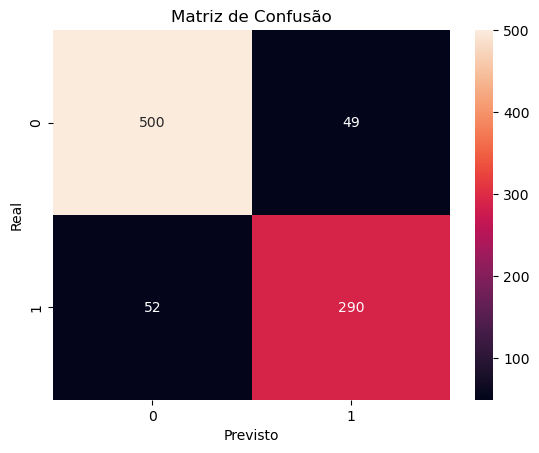

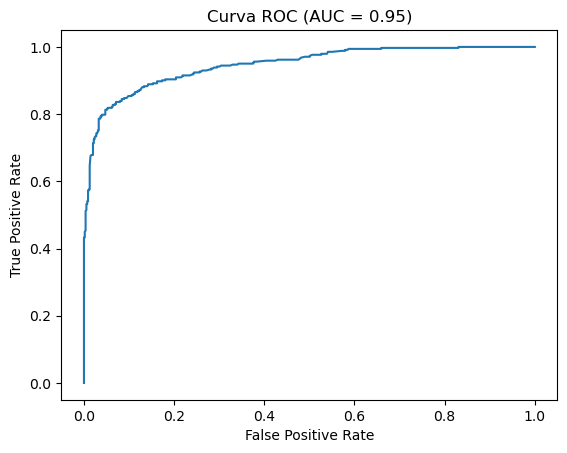

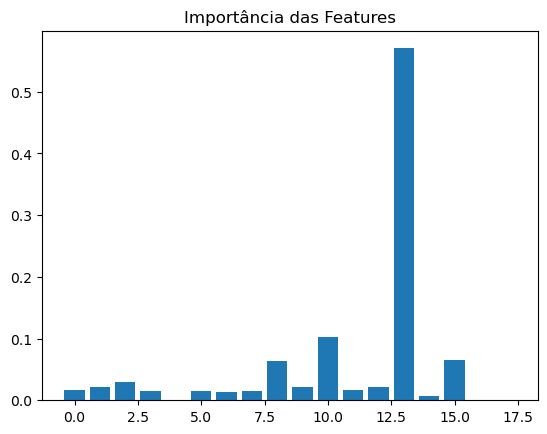

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# PREVISÃO NO TREINO
y_pred = grid.best_estimator_.predict(X)
y_prob = grid.best_estimator_.predict_proba(X)[:,1]

# MATRIZ DE CONFUSÃO

cm = confusion_matrix(y, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

# CURVA ROC

fpr, tpr, _ = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.title(f"Curva ROC (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# IMPORTÂNCIA DAS FEATURES

model = grid.best_estimator_.named_steps['classifier']
importances = model.feature_importances_

plt.figure()
plt.bar(range(len(importances)), importances)
plt.title("Importância das Features")
plt.show()
